# Understanding Diagnostic Tests

In [1]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import logit
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score
%matplotlib inline
sns.set(style = 'whitegrid')

main = pd.read_csv('data/diag.csv')
main.columns = main.columns.str.lower()
main['sex'] = np.where(main.sex == 'M', 'm+', 'm-')
main.loc[main.sex == 'm-', 'haemoglobins'] = main.loc[main.sex == 'm-', 'haemoglobins'] - 1

## Example Dataset

Dataset from [Kaggle Competition](https://www.kaggle.com/ivanmsiegfried/hematology).

Hematological parameters from 3309 persons with 1743 males (52.7%).

In [2]:
main.head()

haematocrit  haemoglobins  erythrocyte  leucocyte  thrombocyte   mch  mchc  \
0         33.8          10.1         4.18        4.6          150  26.6  32.8   
1         44.6          14.0         6.86        6.3          232  20.4  31.4   
2         42.9          13.0         4.57        6.2          336  30.6  32.6   
3         41.9          13.4         4.67        3.5          276  30.8  34.4   
4         40.6          13.3         4.85       14.9          711  27.4  32.8   

    mcv  age sex  source  
0  80.9   33  m-       1  
1  65.0   36  m+       0  
2  93.9   70  m-       0  
3  89.7   18  m-       0  
4  83.7   36  m+       0

## Question came in my mind ...

Can **Hemoglobin** be used to **classify** a person as **male or female**?

**Hemoglobin level** acts as a **Diagnostic Test** to diagnose a person as **male or female**.

Two groups are: **M+** and **M-**

## What is a diagnostic test?

- **Test** whose job in this world is to **classify** an entity into one of the two mutually exclusive **classes**

- Usually diagnostic test emits out some **continuous value**

- Some **cutoff is assigned to the value of diagnostic test**, like Hb < 13 gm/dl in males for anemia, MRD < 0.01 for B-ALL, BM blasts > 20% for acute leukemia, etc.

## Classification by the diagnostic test is not the TRUTH

- Diagnostic test does **make mistakes (error)**

    - **Misclassification errors**
    
- **Dangers of dichotomisation**

    - Misclassification at boundary

## Diagnostic test as a probability assigner

- Better way is to **assign a probability of occurrence of a class** after obtaining a **particular value of diagnostic test**

- Eg., Probability of Megaloblastic Anemia (MCV = 100 fl) = 70%, Probability of Megaloblastic Anemia (MCV = 90 fl) = 40%, etc.

- Usually not done in routine practice, as **decision of cut off value** depends on the user.

## Lets visualise the hemoglobin among males and not males

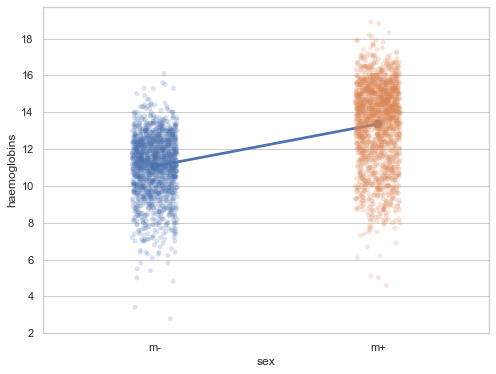

In [3]:
f, ax = plt.subplots(figsize = (8, 6))
sns.stripplot(x = 'sex', y = 'haemoglobins', data = main, alpha = 0.2, ax = ax)
_ = sns.pointplot(x = 'sex', y = 'haemoglobins', data = main, ax = ax)

## Approach 1: Hb as a classifier

A **cut off** value of Hb is to be decided

If **Hb > cut off value:** we say that the **entity is M+**, else, we say that entity is M- 

## How to select cut off value?

- Most difficult issue

- Needs thorough **domain specific knowledge** and knowledge about the **cost of misclassification error**

- Usual methods are:

    - Data driven (not preferred)
    
    - **Decided by experts and consensus**

## Let us select cut off Hb to be 12 g/dl

For a given person,

if Hb < 12 g/dl, the test will assign class M- to it,

else it will assign class M+

In [4]:
main['assigned_sex'] = np.where(main.haemoglobins < 12, 'm-', 'm+')

In [5]:
main[['assigned_sex', 'sex']].head(10)

assigned_sex sex
0           m-  m-
1           m+  m+
2           m+  m-
3           m+  m-
4           m+  m+
5           m-  m-
6           m-  m+
7           m+  m+
8           m-  m+
9           m+  m+

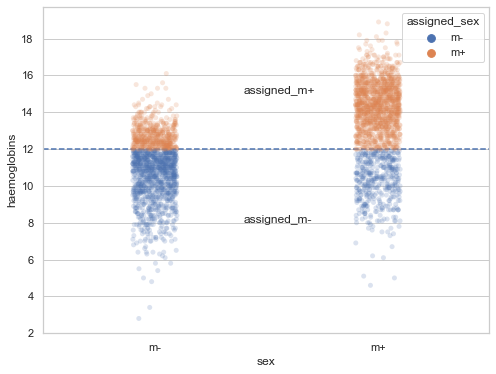

In [6]:
f, ax = plt.subplots(figsize = (8, 6))
sns.stripplot(x = 'sex', y = 'haemoglobins', hue = 'assigned_sex', data = main, alpha = 0.2, ax = ax)
ax.axhline(12, linestyle = 'dashed')
ax.text(0.4, 15, 'assigned_m+')
_ = ax.text(0.4, 8, 'assigned_m-')

### The test is making mistakes

In [7]:
pd.crosstab(main.assigned_sex, main.sex)

sex             m+    m-
assigned_sex            
m+            1309   503
m-             434  1063

## Probability vs odds: concepts required in assessing diagnostic test performance

- Both are different representations of the same underlying chance of occurrence

$$
Prob\ (m+) = \frac{num\ m+}{total}
$$

$$
Odds\ (m+) = \frac{num\ m+}{num\ m-} = \frac{Prob\ (m+)}{Prob\ (m-)}
$$

- Probability of 0.5 means odds of 1

- Probability of 0 means odds of 0.

- Probability of 1 means odds of $\infty$.

### Probabilities of M+ and M-

In [8]:
main['sex'].value_counts()

m+    1743
m-    1566
Name: sex, dtype: int64

In [9]:
main['sex'].value_counts(normalize = True)

m+    0.526745
m-    0.473255
Name: sex, dtype: float64

### Odds of M+

In [10]:
xx = main['sex'].value_counts()
xx[0] / xx[1]

1.1130268199233717

### Odds of M-

In [11]:
xx[1] / xx[0]

0.8984509466437177

## Performance of diagnostic test

**Hb > 12 g/dl** to correctly classify a person as **M+** and 

**Hb $\leq$ 12 g/dl** to correctly classify a person as **M-**

### 1. Performance of the test in M+

In [12]:
main.loc[main.sex == 'm+', 'assigned_sex'].value_counts(normalize = True)

m+    0.751004
m-    0.248996
Name: assigned_sex, dtype: float64

#### Sensitivity

**Proportion** of persons **correctly classified as M+ in M+**

### 2. Performance of the test in M-

In [13]:
main.loc[main.sex == 'm-', 'assigned_sex'].value_counts(normalize = True)

m-    0.678799
m+    0.321201
Name: assigned_sex, dtype: float64

#### Specificity

**Proportion** of persons **correctly classified as M- in M-**

### Combining performance of the test in M+ and M-

**Sensitivity** is a measure of test performance in **M+**

**Specificity** is a measure of test performance in **M-**

**How do we combine sensitivity and specificity in a single measure to assess performance of the test both in M+ and M-?**

#### 1. Diagnostic accuracy

**Proportion of concordant results**, i.e., when test is **correctly classifying the entities**

In [14]:
main.loc[main.assigned_sex == main.sex, :].shape[0] / main.shape[0]

0.7168328800241764

#### 2. Positive Likelihood Ratio

$$
PLR = \frac{Proportion\ of\ test\ detecting\ M+\ in\ M+}{Proportion\ of\ test\ detecting\ M+\ in\ M-}
= \frac{sensitivity}{1\ -\ specificity}
$$

- Compares the **performance of test detecting M+** in M+ and M- persons

- **Higher values:** Test is highly performant in **detecting M+ in M+ persons**, when compared to M- persons

- **PLR > 10** is highly significant

- Denotes **number of times the odds of M+ increases**, if test detects M+

In [15]:
m_pos = main.loc[main.sex == 'm+', :]
m_neg = main.loc[main.sex == 'm-', :]

In [16]:
round((m_pos.loc[m_pos.assigned_sex == 'm+', :].shape[0] / m_pos.shape[0]) / \
(m_neg.loc[m_neg.assigned_sex == 'm+', :].shape[0] / m_neg.shape[0]), 3)

2.338

#### 3. Negative Likelihood Ratio

$$
NLR = \frac{Proportion\ of\ test\ detecting\ M-\ in\ M+}{Proportion\ of\ test\ detecting\ M-\ in\ M-}
= \frac{1 - sensitivity}{specificity}
$$

- Compares the **performance of test detecting M-** in M+ and M- persons

- **Lower values:** Test is highly performant in **detecting M- in M- persons**, when compared to M+ persons

- **NLR < 0.1** is highly significant

- Denotes **number of times the odds of M+ decreases**, if test detects M-

In [17]:
round((m_pos.loc[m_pos.assigned_sex == 'm-', :].shape[0] / m_pos.shape[0]) / \
(m_neg.loc[m_neg.assigned_sex == 'm-', :].shape[0] / m_neg.shape[0]), 3)

0.367

## P(T | D) $\neq$ P(D | T)

- Till now we have calculated measures of test performance in **known M+ and M-**

- We have calculated probability of test positivity and negativity in M+ and M- persons

In clinical practice, what we desire is

**Given that test says M+, what is the probability that the entity is really M+**

and

**Given that test says M-, what is the probability that the entity is really M-**

### 1. Positive Predictive Value (PPV)

**Given that test says M+, what is the probability that the entity is really M+**

$$
Odds\ (M+)\ given\ test\ says\ M+\ =\ Odds (M+)\ *\ PLR
$$

In addition to PLR, **prevalence of M+ is required** for calculating PPV. It is a tricky job and it will change based on the situation.

Job of **PLR** is to **change the odds of M+**.

In [18]:
(xx[0] / xx[1]) * (m_pos.loc[m_pos.assigned_sex == 'm+', :].shape[0] / m_pos.shape[0]) / \
(m_neg.loc[m_neg.assigned_sex == 'm+', :].shape[0] / m_neg.shape[0])

2.6023856858846917

### 2. Negative predictive Value (NPV)

**Given that test says M-, what is the probability that the entity is really M-**

$$
Odds\ (M-)\ given\ test\ says\ M-\ =\ Odds (M-)\ *\ \frac{1}{NLR}
$$

In addition to NLR, **prevalence of M- is required** for calculating NPV. It is a tricky job and it will change based on the situation.

Job of **NLR** is to **change the odds of M-**.

In [19]:
(xx[1] / xx[0]) * 1 / ((m_pos.loc[m_pos.assigned_sex == 'm-', :].shape[0] / m_pos.shape[0]) / \
(m_neg.loc[m_neg.assigned_sex == 'm-', :].shape[0] / m_neg.shape[0]))

2.4493087557603688

## Approach 2: Hb as a Probability Assigner

In [20]:
main['hb_cat'] = [i.mid for i in pd.qcut(main.haemoglobins, 6)]
main['ismale'] = 1 * (main.sex == 'm+')

hb_df = main.groupby('hb_cat')['sex'].apply(lambda x: (1 * (x == 'm+')).mean()).reset_index()

fit = logit('ismale ~ haemoglobins', data = main).fit()

pred_m_orig = fit.predict()
hbs = np.linspace(np.min(main.haemoglobins), np.max(main.haemoglobins), 100)
pred_m = fit.predict({'haemoglobins': hbs})

Optimization terminated successfully.
         Current function value: 0.548698
         Iterations 6


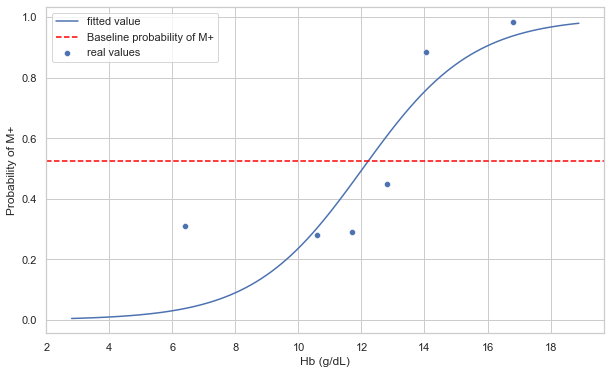

In [21]:
f, ax = plt.subplots(figsize = (10, 6))

plt.plot(hbs, pred_m, '-', label = 'fitted value')
sns.scatterplot(x = 'hb_cat', y = 'sex', data = hb_df, ax = ax, label = 'real values')
ax.axhline((1 * (main.sex == 'm+')).mean(), linestyle = 'dashed', color = 'red', \
           label = 'Baseline probability of M+')
ax.legend()
ax.set_xlabel('Hb (g/dL)')
_ = ax.set_ylabel('Probability of M+')

## Receiver Operating Characteristic (ROC)

In [22]:
fp, tp, thresh = roc_curve(main['ismale'], main['haemoglobins'])

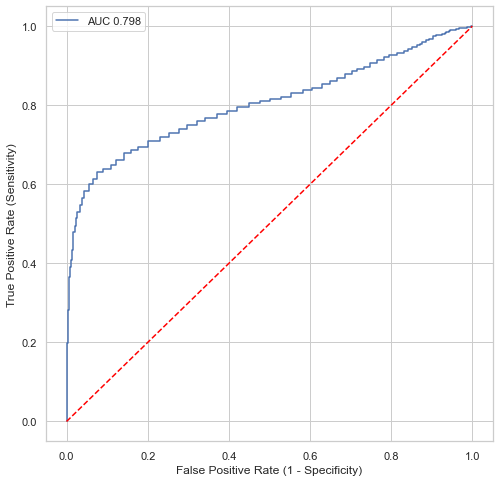

In [23]:
f, ax = plt.subplots(figsize = (8, 8))
ax.step(fp, tp, label = f"AUC {roc_auc_score(main['ismale'], pred_m_orig):.3f}")
ax.plot([0, 1], [0, 1], linestyle = 'dashed', color = 'red')
ax.set_xlabel('False Positive Rate (1 - Specificity)')
ax.set_ylabel('True Positive Rate (Sensitivity)')
_ = ax.legend()

## Stages in conduct of studies assessing diagnostic tests

### 1. Test done to patients with known disease status

- **Assesses performance of diagnostic test**

![](figs/diag_test_scen_1.svg)

### 2. Test done to patients before knowing disease status

- **Assessment of performance of diagnostic test**

- **Estimation of prevalence (odds) of disease** and **calculation of PPV and NPV**

![](figs/diag_test_scen_2.svg)

### 3. Applied to patients in one of the arms after randomisation and assessing difference in clinically relevant outcome

- **Most realistic assessment of diagnostic test**

![](figs/diag_test_scen_3.svg)

## Understanding units of measurement (conventional vs SI units)

- Across the world, different measurement systems were used (Metric System, British System, Indian System, etc.)

- **SI unit system:** Developed to make the measurements uniformly all across the world

- Gradual adoption of SI unit system in India

- Different reporting in different laboratories, **leads to confusion**

## SI units:

quantity | unit
---------|-----
mass     | gram (g)
volume   | litre (L)
number   | mole (mol)
pressure | pascal (Pa)
energy   | joules (J)

### Scales

**kilo (k)** (1000 x) $\rightarrow$ **base** $\rightarrow$ **deci (d)** (0.1 x) $\rightarrow$ **centi (c)** (0.01 x) $\rightarrow$ **milli (m)** (0.001 x) $\rightarrow$ **micro ($\mu$)** (10$^{-6}$ x) $\rightarrow$ **nano (n)** (10$^{-9}$ x) $\rightarrow$ **pico (p)** (10$^{-12}$ x) $\rightarrow$ **femto (f)** (10$^{-15}$ x)

## Conversion

- Get hold of appropriate conversion factor (CF)
- **SI unit = CF x Conventional unit**

https://connect.springerpub.com/content/book/978-0-8261-3914-6/back-matter/bmatter2

https://connect.springerpub.com/content/book/978-0-8261-3914-6/back-matter/bmatter3

http://www.scymed.com/en/smnxpf/pfxdc017.htm